# Import Libraries

In [1]:
import time
# Start time to build random forest model
start_time = time.time()

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LogisticRegressionModel, RandomForestClassificationModel
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.types import StructType, StructField, FloatType, StringType
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from pyspark.sql.functions import isnan, when, count, col
import pandas as pd
import numpy as np
import time

# Create Spark Session and SPARK DF

In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("CancerML") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Define schema of csv data
schema = StructType([
    StructField("id", FloatType(), True),
    StructField("diagnosis", StringType(), True),
    StructField("radius_mean", FloatType(), True),
    StructField("texture_mean", FloatType(), True),
    StructField("perimeter_mean", FloatType(), True),
    StructField("area_mean", FloatType(), True),
    StructField("smoothness_mean", FloatType(), True),
    StructField("compactness_mean", FloatType(), True),
    StructField("concavity_mean", FloatType(), True),
    StructField("concave_points_mean", FloatType(), True),
    StructField("symmetry_mean", FloatType(), True),
    StructField("fractal_dimension_mean", FloatType(), True),
    StructField("radius_se", FloatType(), True),
    StructField("texture_se", FloatType(), True),
    StructField("perimeter_se", FloatType(), True),
    StructField("area_se", FloatType(), True),
    StructField("smoothness_se", FloatType(), True),
    StructField("compactness_se", FloatType(), True),
    StructField("concavity_se", FloatType(), True),
    StructField("concave_points_se", FloatType(), True),
    StructField("symmetry_se", FloatType(), True),
    StructField("fractal_dimension_se", FloatType(), True),
    StructField("radius_worst", FloatType(), True),
    StructField("texture_worst", FloatType(), True),
    StructField("perimeter_worst", FloatType(), True),
    StructField("area_worst", FloatType(), True),
    StructField("smoothness_worst", FloatType(), True),
    StructField("compactness_worst", FloatType(), True),
    StructField("concavity_worst", FloatType(), True),
    StructField("concave_points_worst", FloatType(), True),
    StructField("symmetry_worst", FloatType(), True),
    StructField("fractal_dimension_worst", FloatType(), True),
])

# Read the CSV file into a DataFrame
file_path = "C:/Users/bwc07/Downloads/project3_data.csv"
df = spark.read.csv(file_path, header=True, schema=schema)
df = df.drop("id")

# Convert to Pandas for display purposes
pandas_df = df.toPandas()
pandas_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.990000,10.380000,122.800003,1001.000000,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.570000,21.770000,132.899994,1326.000000,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.570000,25.530001,152.500000,1709.000000,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.420000,20.379999,77.580002,386.100006,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.910000,26.500000,98.870003,567.700012,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.290001,14.340000,135.100006,1297.000000,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.540001,16.670000,152.199997,1575.000000,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Checking for null or NaN values in DataFrame
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave_points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave_points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave_points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [31]:
# Count of diagnosis data
df.groupBy("diagnosis").count().show()

+---------+-----+
|diagnosis|count|
+---------+-----+
|        B|  357|
|        M|  212|
+---------+-----+



In [5]:
# Print the Statistics of Each Column
pandas_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127290,19.296684,91.969032,654.889038,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269192,25.677235,107.261230,880.583130,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524048,4.301817,24.298983,351.914093,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833241,6.146256,33.602535,569.356873,0.022832,0.157337,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790001,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.199997,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.169998,420.299988,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110001,515.299988,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.870001,86.239998,551.099976,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660004,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.799999,104.099998,782.700012,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790001,29.719999,125.400002,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110001,39.279999,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040001,49.540001,251.199997,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
# Make the features and label column
feature_cols = [col for col in df.columns if col != 'diagnosis']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
label_indexer = StringIndexer(inputCol="diagnosis", outputCol="label")

#### Random Forest

In [7]:
# Start time to build random forest model
start_time_rf = time.time()

In [8]:
# Create a pipeline of the features and the label
pipeline = Pipeline(stages=[assembler, label_indexer])

# Fit and transform using the pipeline
df_rf = pipeline.fit(df).transform(df)

In [9]:
# Print the Results of Adding the features and label column to the df_rf
#pd_df_rf = df_rf.toPandas()
#pd_df_rf.head()

In [10]:
# Split the data into 80% for training and 20% for testing sets
(training_data, test_data) = df.randomSplit([0.8, 0.2], seed=123)

In [11]:
# Print the first few rows of selected training data
#print("Training Data:")
#training_df = training_data.toPandas()
#training_df.head()

In [12]:
# Print the first few rows of selected test data
#print("Test Data:")
#test_df = test_data.toPandas()
#test_df.head()

In [13]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="features")

# Create a pipeline with features, label, and the rf classifier
pipeline_rf = Pipeline(stages=[assembler, label_indexer, rf_classifier])

In [14]:
# Make parameter grid for cross-validation
param_grid_rf = (ParamGridBuilder()
               .addGrid(rf_classifier.maxDepth, [4, 8, 16])
               .addGrid(rf_classifier.maxBins, [5, 10, 20])
               .addGrid(rf_classifier.numTrees, [4, 16, 64])
               .build())

# Create BinaryClassificationEvaluator
evaluator_rf = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

# Cross-Validator to find best model
crossval_rf = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=param_grid_rf,
                          evaluator=evaluator_rf, numFolds=10)

# Train the best model with training data
cv_model_rf = crossval_rf.fit(training_data)
best_model_rf = cv_model_rf.bestModel

# End time for building random forest model
end_time_rf = time.time()

In [15]:
# Predictions based on the test data
predictions_rf = best_model_rf.transform(test_data)
predictions_rf.select("rawPrediction", "Probability", "Prediction").show(truncate=False)

+---------------------------------------+-----------------------------------------+----------+
|rawPrediction                          |Probability                              |Prediction|
+---------------------------------------+-----------------------------------------+----------+
|[62.42335666612068,1.5766433338792893] |[0.9753649479081361,0.024635052091863906]|0.0       |
|[62.57035786814022,1.4296421318597374] |[0.9776618416896916,0.02233815831030841] |0.0       |
|[62.47786100351791,1.5221389964820493] |[0.976216578179968,0.023783421820032038] |0.0       |
|[61.78691385541993,2.213086144580038]  |[0.9654205289909369,0.034579471009063105]|0.0       |
|[54.22913611107202,9.77086388892796]   |[0.8473302517355006,0.15266974826449942] |0.0       |
|[62.41505940782342,1.5849405921765478] |[0.9752353032472414,0.02476469675275857] |0.0       |
|[62.57300584321811,1.4269941567818558] |[0.9777032163002835,0.022296783699716508]|0.0       |
|[61.33162298564394,2.6683770143560155] |[0.958306

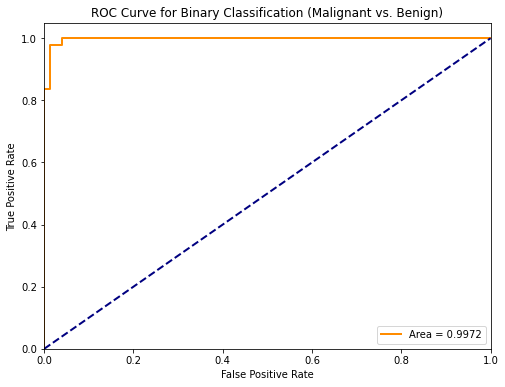

In [16]:
# Compute area of ROC
roc_auc_rf = evaluator_rf.evaluate(predictions_rf)

# Convert Spark DataFrame to Pandas DataFrame
pred_pd_rf = predictions_rf.select("label", "Probability").toPandas()

# Compute ROC curve
fpr, tpr, _ = roc_curve(pred_pd_rf["label"], pred_pd_rf["Probability"].apply(lambda x: x[1]))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Area = {round(roc_auc_rf,4)}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification (Malignant vs. Benign)')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Calculate and print the elapsed time
elapsed_time_rf = end_time_rf - start_time_rf
print("Time taken: {:.4f} seconds".format(elapsed_time_rf))

Time taken: 451.5411 seconds


#### Logistic Regression

In [18]:
# Start time to build random forest model
start_time_lr = time.time()

In [19]:
# Create a Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Create a pipeline with the necessary stages
pipeline_lr = Pipeline(stages=[assembler, label_indexer, lr])

In [20]:
# Set up the parameter grid for cross-validation
param_grid_lr = (ParamGridBuilder()
    .addGrid(lr.regParam, [0, 0.05, 0.1])
    .addGrid(lr.elasticNetParam, [0, 0.05, 0.1])
    .addGrid(lr.maxIter, [5, 20, 30])
    .addGrid(lr.family, ["auto", "binomial"])
    .build())

# Create BinaryClassificationEvaluator
evaluator_lr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

# Set up the cross-validator
crossval_lr = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=param_grid_lr,
                          evaluator=evaluator_lr, numFolds=10)

# Train the model
cv_model_lr = crossval_lr.fit(training_data)

best_model_lr = cv_model_lr.bestModel

# End time for building random forest model
end_time_lr = time.time()

# Make predictions on the test data
predictions_lr = best_model_lr.transform(test_data)

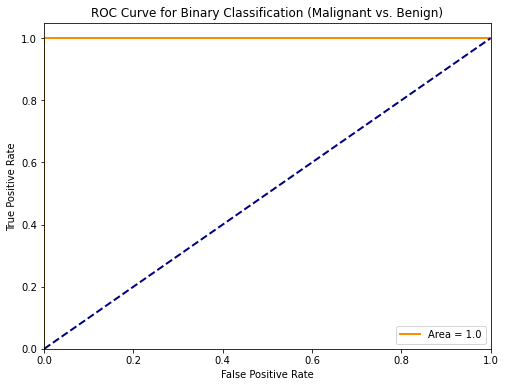

In [21]:
# Evaluate the model using BinaryClassificationEvaluator
roc_auc_lr = evaluator_lr.evaluate(predictions_lr)

# Convert Spark DataFrame to Pandas DataFrame
predictions_pd_lr = predictions_lr.select("label", "Probability").toPandas()

# Compute ROC curve
fpr_lr, tpr_lr, _ = roc_curve(predictions_pd_lr["label"], predictions_pd_lr["Probability"].apply(lambda x: x[1]))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f"Area = {roc_auc_lr}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification (Malignant vs. Benign)')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Calculate and print the elapsed time
elapsed_time_lr = end_time_lr - start_time_lr
print("Time taken: {:.4f} seconds".format(elapsed_time_lr))

Time taken: 550.3343 seconds


# Comparison of Models

### Logistic Regression Model

In [23]:
print("Best Model Type: ", type(best_model_lr))

# If pipeline, get stages
if isinstance(best_model_lr, PipelineModel):
    stages = best_model_lr.stages
    for stage in stages:
        print("Stage: ", type(stage))
        if isinstance(stage, LogisticRegressionModel):
            # Properties of the model
            print("Coefficients: ", stage.coefficients)
            print("Intercept: ", stage.intercept)
            # Add more properties as needed

# If only one model
elif isinstance(best_model_lr, LogisticRegressionModel):
    print("Coefficients: ", best_model_lr.coefficients)
    print("Intercept: ", best_model_lr.intercept)

print("All evaluated models: ", cv_model_lr.avgMetrics)

Best Model Type:  <class 'pyspark.ml.pipeline.PipelineModel'>
Stage:  <class 'pyspark.ml.feature.VectorAssembler'>
Stage:  <class 'pyspark.ml.feature.StringIndexerModel'>
Stage:  <class 'pyspark.ml.classification.LogisticRegressionModel'>
Coefficients:  [0.08784817018867676,0.07295357262840063,0.012537382844367062,0.0008186717288054263,7.898413936318233,1.4292682405382169,3.4984945004716956,8.658814836852187,2.151537807516558,-23.37998281276722,1.22430066824204,-0.06739642024562198,0.13021241475688744,0.005590269736082289,0.9197865168545496,-6.741334151004932,-1.4388350008544026,15.525224687188206,-10.323054801203133,-52.594867607847675,0.08382020150676563,0.0668988187273371,0.011229775122671202,0.0006327467494914415,12.62989967424079,0.941178487557935,1.4338464001510784,5.862400376071905,4.731455684772189,6.347704148489397]
Intercept:  -15.76350722756046
All evaluated models:  [0.9927458260369552, 0.9927458260369552, 0.9784241658522019, 0.9784241658522019, 0.976517497114888, 0.9765174

In [24]:
# Print Best Hyperaramters for Logistic Regression
print("Best Parameters for Tuning:")

# Get the best paramters
best_params_index = np.argmax(cv_model_lr.avgMetrics)
best_params = cv_model_lr.getEstimatorParamMaps()[best_params_index]

for param, value in best_params.items():
    print(f"{param.name}: {value}")

# Sort by average metric
sorted_models = sorted(
    zip(cv_model_lr.getEstimatorParamMaps(), cv_model_lr.avgMetrics),
    key=lambda x: x[1],
    reverse=True
)

temp = []
temp2 = []
for i, (params, auc) in enumerate(sorted_models):
    temp.append(i+1)
    temp.append(params)
    temp.append(auc)
    temp2.append(temp)
    temp = []


Best Parameters for Tuning:
regParam: 0.05
elasticNetParam: 0.0
maxIter: 20
family: auto


In [25]:
eval_models_lr = pd.DataFrame(temp2)

eval_models_lr.head()

,0,1,2
0,1,{LogisticRegression_5bcb09fc8dc3__regParam: 0....,0.993385
1,2,{LogisticRegression_5bcb09fc8dc3__regParam: 0....,0.993385
2,3,{LogisticRegression_5bcb09fc8dc3__regParam: 0....,0.993385
3,4,{LogisticRegression_5bcb09fc8dc3__regParam: 0....,0.993385
4,5,{LogisticRegression_5bcb09fc8dc3__regParam: 0....,0.993267


In [26]:
lr_model = best_model_lr.stages[-1]

# Print coefficients
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

# Summary of model
training_summary = lr_model.summary

# Print precision recall
training_summary.pr.show()

# Print F-Measure
print("F-Measure: " + str(training_summary.fMeasureByThreshold.show()))

Coefficients: [0.08784817018867676,0.07295357262840063,0.012537382844367062,0.0008186717288054263,7.898413936318233,1.4292682405382169,3.4984945004716956,8.658814836852187,2.151537807516558,-23.37998281276722,1.22430066824204,-0.06739642024562198,0.13021241475688744,0.005590269736082289,0.9197865168545496,-6.741334151004932,-1.4388350008544026,15.525224687188206,-10.323054801203133,-52.594867607847675,0.08382020150676563,0.0668988187273371,0.011229775122671202,0.0006327467494914415,12.62989967424079,0.941178487557935,1.4338464001510784,5.862400376071905,4.731455684772189,6.347704148489397]
Intercept: -15.76350722756046
+--------------------+---------+
|              recall|precision|
+--------------------+---------+
|                 0.0|      1.0|
|0.005917159763313609|      1.0|
|0.011834319526627219|      1.0|
| 0.01775147928994083|      1.0|
|0.023668639053254437|      1.0|
|0.029585798816568046|      1.0|
| 0.03550295857988166|      1.0|
| 0.04142011834319527|      1.0|
|0.0473372

In [27]:
# Evaluate accuracy and print
accuracy_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions_lr)
print("Accuracy: {:.4f}".format(accuracy))

# Evaluate F1 score and print
f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")
f1 = f1_evaluator.evaluate(predictions_lr)
print("F1 Score: {:.4f}".format(f1))

# Evaluate precision and print
precision_evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions_lr)
print("Precision: {:.4f}".format(precision))

# Evaluate recall and print
recall_evaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions_lr)
print("Recall: {:.4f}".format(recall))

Accuracy: 0.9915
F1 Score: 0.9914
Precision: 0.9916
Recall: 0.9915


### Random Forest Model

In [28]:
# Predictions for evaluation
sample_predictions_rf = predictions_rf.select("Prediction", "label").sample(False, 1.0, seed=42).collect()

# Select true and predicted values
y_pred_rf = [row["Prediction"] for row in sample_predictions_rf]
y_true_rf = [row["label"] for row in sample_predictions_rf]

# Calculate accuracy, precision, recall, and F1 score
accuracy_rf = accuracy_score(y_true_rf, y_pred_rf)
precision_rf = precision_score(y_true_rf, y_pred_rf)
recall_rf = recall_score(y_true_rf, y_pred_rf)
f1_rf = f1_score(y_true_rf, y_pred_rf)

# Print accuracy, precision, recall, and F1 score
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print(f"Precision: {precision_rf * 100:.2f}%")
print(f"Recall: {recall_rf * 100:.2f}%")
print(f"F1 Score: {f1_rf * 100:.2f}%")

Accuracy: 97.44%
Precision: 95.45%
Recall: 97.67%
F1 Score: 96.55%


In [29]:
best_model_rf = cv_model_rf.bestModel

# Print best model type
print("Best Model Type: ", type(best_model_rf))

if isinstance(best_model_rf, PipelineModel):
    stages_rf = best_model_rf.stages
    for stage_rf in stages_rf:
        print("Stage: ", type(stage_rf))
        if isinstance(stage_rf, RandomForestClassificationModel): 
            print("Num Trees: ", stage_rf.getNumTrees)
            print("Max Depth: ", stage_rf.getMaxDepth)
            print("Min Samples Split: ", stage_rf.getMinInstancesPerNode)
            print("Min Samples Leaf: ", stage_rf.getMinInfoGain)

# Find the best hyperparameters
best_params = list(zip(cv_model_rf.getEstimatorParamMaps(), cv_model_rf.avgMetrics))
best_params.sort(key=lambda x: x[1], reverse=True)  # Sort by the highest average metric

# Print best hyperparameters and its average metric
print("Best Parameters: ", best_params[0][0])
print("Best Average Metric: ", best_params[0][1])

# Print performance of all models
print("All evaluated models: ", best_params)


Best Model Type:  <class 'pyspark.ml.pipeline.PipelineModel'>
Stage:  <class 'pyspark.ml.feature.VectorAssembler'>
Stage:  <class 'pyspark.ml.feature.StringIndexerModel'>
Stage:  <class 'pyspark.ml.classification.RandomForestClassificationModel'>
Num Trees:  64
Max Depth:  <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_82fa072dee97, numTrees=64, numClasses=2, numFeatures=30>
Min Samples Split:  <bound method _DecisionTreeParams.getMinInstancesPerNode of RandomForestClassificationModel: uid=RandomForestClassifier_82fa072dee97, numTrees=64, numClasses=2, numFeatures=30>
Min Samples Leaf:  <bound method _DecisionTreeParams.getMinInfoGain of RandomForestClassificationModel: uid=RandomForestClassifier_82fa072dee97, numTrees=64, numClasses=2, numFeatures=30>
Best Parameters:  {Param(parent='RandomForestClassifier_82fa072dee97', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1

In [30]:
# End time for building random forest model
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print("Time taken: {:.4f} seconds".format(elapsed_time))

Time taken: 1031.5014 seconds
